# Linear Regression Model¶

Linear Regression is a statistical technique used to model the relationship between a dependent variable and one or more independent variables. It assumes a linear connection, where the model aims to find the best-fit line that minimizes the difference between predicted and actual values.

In the equation y=mx+b, y is the dependent variable, x is the independent variable,m is the slope, and b is the intercept.

Linear Regression is fundamental for tasks like prediction and trend analysis, offering insights into the correlation between variables. Its simplicity and interpretability make it a widely employed method in various fields for quantitative analysis.

In [12]:
#import necessary liabraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Download data
stock_symbol = "TCS"
start_date = "2013-12-31"
end_date = "2023-12-30"
data = yf.download(stock_symbol, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [13]:
#generate target variable
data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

In [4]:
# Generate features
features_list = []

#Moving Average
for i in [10,15,25,35]:
    col_name = 'SMA_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)

# RSI
window_length = 14
diff = data['Close'].diff(1)
gain = diff.where(diff > 0, 0)
loss = -diff.where(diff < 0, 0)
avg_gain = gain.rolling(window=window_length).mean()
avg_loss = loss.rolling(window=window_length).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))
features_list.append('RSI')

# Bollinger band
window_length = 20
data['MA'] = data['Close'].rolling(window=window_length).mean()
data['std_dev'] = data['Close'].rolling(window=window_length).std()
data['UpperBand'] = data['MA'] + 2 * data['std_dev']
data['LowerBand'] = data['MA'] - 2 * data['std_dev']
features_list.extend(['UpperBand', 'LowerBand'])
data.dropna(inplace=True)
    
print(data.head())

                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
2014-02-21  35.509998  35.959999  35.040001  35.169998  32.876305   240900   
2014-02-24  34.000000  34.480000  33.040001  34.110001  31.885435  1427100   
2014-02-25  33.650002  33.980000  32.799999  33.310001  31.137611   544400   
2014-02-26  33.689999  35.250000  33.320000  34.930000  32.651958   633500   
2014-02-27  34.900002  36.099998  34.500000  35.970001  33.624130   315300   

            cc_returns     target  SMA_10     SMA_15   SMA_25     SMA_35  \
Date                                                                       
2014-02-21   -0.013556  34.110001  37.012  36.836666  37.1660  38.216857   
2014-02-24   -0.030603  33.310001  36.581  36.660666  36.9740  37.940571   
2014-02-25   -0.023733  34.930000  36.094  36.472000  36.7712  37.673429   
2014-02-26    0.047488  35.970001  35.672  36.350667  36.6312  37.443429 

In [5]:
# Generate train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data[features_list].iloc[:-1],
    data.iloc[:-1]['target'],
    test_size=0.25,
    shuffle=False
)


In [6]:

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.describe().round(2)

,SMA_10,SMA_15,SMA_25,SMA_35,RSI,UpperBand,LowerBand
count,1860.00,1860.00,1860.00,1860.00,1860.00,1860.00,1860.00
mean,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.08,-1.07,-1.06,-1.05,-2.66,-1.10,-1.07
25%,-0.71,-0.70,-0.70,-0.68,-0.67,-0.72,-0.70
50%,-0.47,-0.47,-0.48,-0.49,0.01,-0.44,-0.50
75%,0.64,0.62,0.62,0.61,0.71,0.68,0.54
max,3.62,3.57,3.55,3.63,2.76,3.36,3.73


In [8]:

# Build model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [9]:
# Evaluate model
y_pred_train = model.predict(X_train_scaled)
print('Model accuracy on training data:', model.score(X_train_scaled, y_train))

y_pred = model.predict(X_test_scaled)
print('Model accuracy on testing data:', model.score(X_test_scaled, y_test))

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)


Model accuracy on training data: 0.9903337418092283
Model accuracy on testing data: 0.9844523577206381
Mean Squared Error: 0.1709582108506072
Mean Absolute Error: 0.3166308185004951


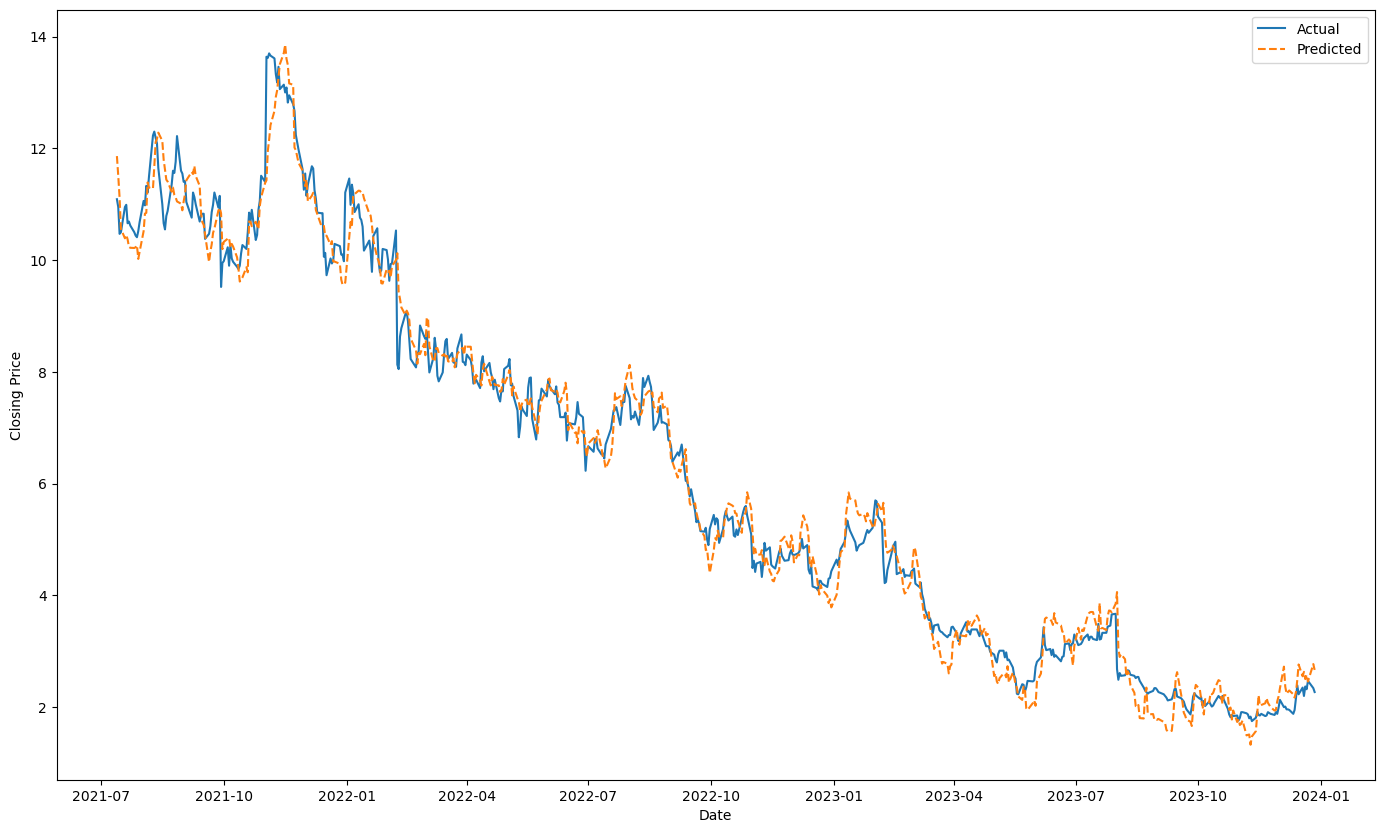

In [10]:


# Plot results
plt.figure(figsize=(17, 10))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, model.predict(X_test_scaled), label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


In [11]:
print(pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}))


            Actual  Predicted
Date                         
2021-07-13   11.09  11.861815
2021-07-14   10.95  11.507400
2021-07-15   10.47  11.118634
2021-07-16   10.50  10.559374
2021-07-19   10.95  10.390549
...            ...        ...
2023-12-20    2.37   2.501637
2023-12-21    2.32   2.579116
2023-12-22    2.47   2.457840
2023-12-26    2.34   2.770929
2023-12-27    2.27   2.665688

[620 rows x 2 columns]
